In [32]:
# from simulation import Simulation
# from results import Results
from vehicle import Vehicle
from utility.parser import read_yaml
from state_models.vehicle_state import VehicleState
import numpy as np
from scipy.optimize._root import root
import matplotlib.pyplot as plt
import PyQt5

In [42]:
#Make freerolling MMDS and Plot fuction
parameters_file = 'vehicles/metric_test.yaml'
car = Vehicle(parameters_file)
vehicle_state = VehicleState(car.params)
x0 = np.array([0.0, 0.0, 0.0])

def freerollMMM(v,psi_dt,eta, body_slip_set, steered_angle_set):
    surface_x = np.zeros((len(body_slip_set),len(steered_angle_set),2))
    surface_y = np.zeros((len(body_slip_set),len(steered_angle_set),3))
    for i, beta in enumerate(body_slip_set):
        for j, delta in enumerate(steered_angle_set):
            def _solve(x):
                r = vehicle_state.eval(v,psi_dt,beta,delta,eta, *x, residuals=True)
                return r
            soln = root(_solve, x0, method='broyden2',options={"xtol":1e-5})
            if soln.success == False:
                print('solution did not converge')
                print(f'beta: {beta} delta: {delta}')
                # print(soln)
            surface_x[i,j,:] = [beta, delta]
            surface_y[i,j,:] = soln.x

    return surface_x, surface_y

def freerollMMDPlot(x_surface_plot, y_surface_plot, plot_title):
    x_scale = 9.81 #Convert m/s^2 to Gs    
    body_slip_sweep = x_surface_plot[:,0,0]
    steered_angle_sweep = x_surface_plot[0,:,1]

    #Trim Plots 
    print("Plot: " + str(plot_title))
    Ay_array = y_surface_plot[:,:,1]
    Ar_array = y_surface_plot[:,:,2]
    maxx, maxy = np.unravel_index(np.argmax(Ay_array), Ay_array.shape)
    trim_Ay = round(Ay_array[maxx, maxy] / x_scale,2) #Gs
    trim_Adr = round(Ar_array[maxx, maxy],2) #rad/s^2
    maxAdr = round(np.max(Ar_array),1) #rad/s^2
    print("Trim Lat Accel (Gs): " + str(trim_Ay) + "  @ Yaw Accel (rad/s^2): " + str(trim_Adr))
    print("Max Yaw Accel (rad/s^2): " + str(maxAdr))

    #Plot
    fig = plt.figure()
    for i, beta in enumerate(body_slip_sweep):
        plt.plot(y_surface_plot[i,:,1]/x_scale,y_surface_plot[i,:,2],'b')
        plt.xlabel('Lateral Acceleration (Gs)')
    for j, delta in enumerate(steered_angle_sweep):
        plt.plot(y_surface_plot[:,j,1]/x_scale,y_surface_plot[:,j,2],'r')
        plt.ylabel('Yaw Acceleration (rad/s^2)')
    plt.title(plot_title)
    plt.show()

    #Plot Info Print
    print("Body Slip (deg) | Steered Angle (deg)")
    for i in range(len(body_slip_sweep)):
        print("Beta: " + str(np.round(np.rad2deg(body_slip_sweep[i]),decimals=0)) + "  Delta: " + str(np.round(np.rad2deg(steered_angle_sweep[i]),decimals=0)))
    
    print(" ")
    print(" ")

Initializing vehicle object
reading "vehicles/metric_test.yaml"


Plot: Velocity = 1 m/s
Trim Lat Accel (Gs): 1.63  @ Yaw Accel (rad/s^2): 1.78
Max Yaw Accel (rad/s^2): 28.3


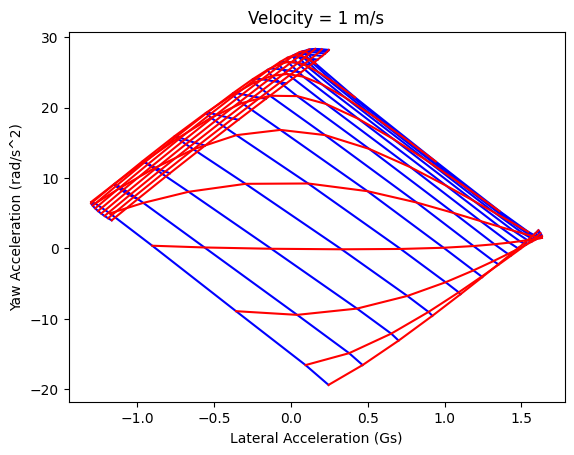

Body Slip (deg) | Steered Angle (deg)
Beta: -8.0  Delta: -25.0
Beta: -7.0  Delta: -22.0
Beta: -6.0  Delta: -19.0
Beta: -5.0  Delta: -15.0
Beta: -3.0  Delta: -12.0
Beta: -2.0  Delta: -9.0
Beta: -1.0  Delta: -6.0
Beta: 0.0  Delta: -2.0
Beta: 1.0  Delta: 1.0
Beta: 2.0  Delta: 4.0
Beta: 3.0  Delta: 7.0
Beta: 5.0  Delta: 10.0
Beta: 6.0  Delta: 14.0
Beta: 7.0  Delta: 17.0
Beta: 8.0  Delta: 20.0
 
 
Plot: Velocity = 12 m/s
Trim Lat Accel (Gs): 1.75  @ Yaw Accel (rad/s^2): 1.7
Max Yaw Accel (rad/s^2): 30.6


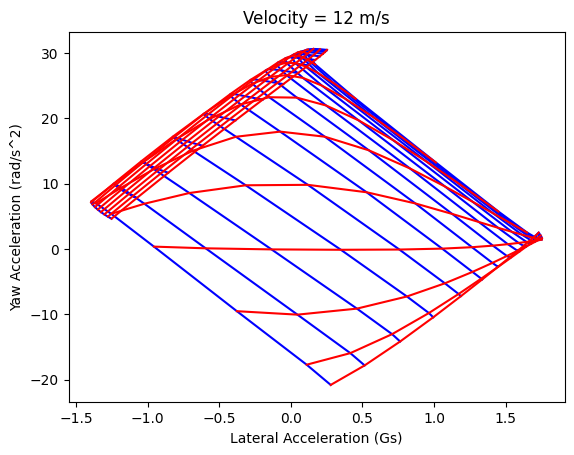

Body Slip (deg) | Steered Angle (deg)
Beta: -8.0  Delta: -25.0
Beta: -7.0  Delta: -22.0
Beta: -6.0  Delta: -19.0
Beta: -5.0  Delta: -15.0
Beta: -3.0  Delta: -12.0
Beta: -2.0  Delta: -9.0
Beta: -1.0  Delta: -6.0
Beta: 0.0  Delta: -2.0
Beta: 1.0  Delta: 1.0
Beta: 2.0  Delta: 4.0
Beta: 3.0  Delta: 7.0
Beta: 5.0  Delta: 10.0
Beta: 6.0  Delta: 14.0
Beta: 7.0  Delta: 17.0
Beta: 8.0  Delta: 20.0
 
 


In [48]:
#Plot MMD Outputs
#velocity = 5.0 #m/s
velocity = np.linspace(1, 12, 2, dtype=int)
yaw_velocity = np.zeros(len(velocity)) #rad/s

#For stead state constant radius
radius = 8.5 #m
yaw_velocity = velocity/radius 

throttle = 0.0 #0-1
body_slips = np.deg2rad(np.linspace(-8,8,15)) #deg
steered_angles = np.deg2rad(np.linspace(-25,20,15)) #deg (at front wheels)

#for in-notebook plots"
%matplotlib inline  
#for interactive plots:
#%matplotlib qt

for i in range(len(velocity)):
    title = ("Velocity = " + str(velocity[i]) + " m/s")
    x_surf, y_surf = freerollMMM(velocity[i], yaw_velocity[i], throttle, body_slips, steered_angles)
    freerollMMDPlot(x_surf, y_surf, title)

#Clockwise -                Final Understeer
#Counterclockwise Skew -    Final Oversteer